#### Clustering asthma-related papers, among publications referring to different kind of coronaviruses

A short descriptin of the background and logic behind this project can be found here: link

In [45]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn import preprocessing
import matplotlib.pyplot as plt
import pandas as pd

In [46]:
import nltk
import string
from nltk.stem import PorterStemmer
from sklearn.cluster import KMeans
from langdetect import detect

In [47]:
import plotly.express as px
import seaborn as sns

In [48]:
from nltk.corpus import stopwords
sw = stopwords.words("english")

The "asthma_data" csv file was created after generating the papers of interest from Kaggle community. In response to the COVID-19 pandemic a large database, the COVID-19 Open Research Dataset (CORD-19), was created and has been made publicly available. CORD-19 is a resource of hundreds of thousands scholarly articles, about COVID-19, SARS-CoV-2, and related coronaviruses.
More information about this open source can be found here:
https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge


For this project, we selected only those papers where the word "asthma" appears at least once in their abstract. As long as all these publications are coronaviruses-related articles, we suppose that each one provides a different relation and among a different context, between asthma and coronaviruses. The papers were firstseparated and then downloaded, in order to be more easily handled.

Below, we convert our csv file to a pandas dataframe and we can have a look at the metadata we picked to examine. Among other information we have each paper's title, DOI, source and the abstract, which is the feature we'll basically need for this project.

In [89]:
asthma_df = pd.read_csv("asthma_data.csv")
asthma_df.head()

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,...,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id,abstract_lower,title_lower
0,qva0jt86,4ba79e54ecf81b30b56461a6aec2094eaf7b7f06,PMC,Relevance of human metapneumovirus in exacerba...,10.1186/1465-9921-6-150,PMC1334186,16371156.0,cc-by,BACKGROUND AND METHODS: Human metapneumovirus ...,2005-12-21,...,Respir Res,NaN,NaN,NaN,document_parses/pdf_json/4ba79e54ecf81b30b5646...,document_parses/pmc_json/PMC1334186.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,NaN,background and methods: human metapneumovirus ...,relevance of human metapneumovirus in exacerba...
1,chz8luni,d68d71553d3a31381c0c3851351f912a9a7be1c9,PMC,Surfactant therapy for acute respiratory failu...,10.1186/cc5944,PMC2206432,17573963.0,cc-by,INTRODUCTION: Exogenous surfactant is used to ...,2007-06-15,...,Crit Care,NaN,NaN,NaN,document_parses/pdf_json/d68d71553d3a31381c0c3...,document_parses/pmc_json/PMC2206432.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2...,NaN,introduction: exogenous surfactant is used to ...,surfactant therapy for acute respiratory failu...
2,3zh8jmc2,fe2000f280297c40bc53ce95d703a9ca6aac19fd,PMC,Differential Regulation of Type I Interferon a...,10.1371/journal.ppat.1000587,PMC2736567,19806178.0,cc-by,A number of paramyxoviruses are responsible fo...,2009-09-18,...,PLoS Pathog,NaN,NaN,NaN,document_parses/pdf_json/fe2000f280297c40bc53c...,document_parses/pmc_json/PMC2736567.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2...,NaN,a number of paramyxoviruses are responsible fo...,differential regulation of type i interferon a...
3,7p3b6tyf,3ccbd07ee1865e4f2afffdb6cc8b6039ab605ee7,PMC,The Tennessee Children's Respiratory Initiativ...,10.1111/j.1440-1843.2010.01743.x,PMC2992986,20409023.0,no-cc,Background and objective: The ‘attack rate’ of...,2010-04-08,...,Respirology,NaN,NaN,NaN,document_parses/pdf_json/3ccbd07ee1865e4f2afff...,document_parses/pmc_json/PMC2992986.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2...,NaN,background and objective: the ‘attack rate’ of...,the tennessee children's respiratory initiativ...
4,xrsyj1tc,fa88fbb8716e5fca7d513bcb5a0a608456a59205,PMC,Analysing the eosinophil cationic protein - a ...,10.1186/1465-9921-12-10,PMC3030543,21235798.0,cc-by,Eosinophil granulocytes reside in respiratory ...,2011-01-14,...,Respir Res,NaN,NaN,NaN,document_parses/pdf_json/fa88fbb8716e5fca7d513...,document_parses/pmc_json/PMC3030543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN,eosinophil granulocytes reside in respiratory ...,analysing the eosinophil cationic protein - a ...


There are 2567 papers containing the word "asthma", among the coronavirus-related publications 

In [90]:
asthma_df.shape

(2567, 21)

Between these docs, there are papers written in english, french, german language and perhaps some more. In this project,for simplicity reasons, we keep only these papers written in english. Like that, we avoid having, later on, clusters of papers only of the same langugae but which have not nevessarily similar context.

To do so, we use the *langdetect* google library to dect the language of the "abstract" column in our dataframe.

In [51]:
asthma_df["lang_detect"] = asthma_df["abstract"].apply(detect)

In [52]:
asthma_df["lang_detect"].value_counts()

en    2528
de      12
fr      12
es       6
pt       4
ru       3
nl       2
Name: lang_detect, dtype: int64

We now have 2528 papers in total, written in english.

In [53]:
asthma_df = asthma_df.loc[asthma_df['lang_detect'] == "en"]
asthma_df.shape

(2528, 22)

We can also have a quick look at the sources where the papers came from:

In [54]:
asthma_after_covid['source_x'].value_counts()

WHO                              700
Medline; PMC                     302
Medline                          221
Elsevier; Medline; PMC           125
MedRxiv; WHO                      62
PMC                               61
Elsevier; PMC                     11
BioRxiv; WHO                       7
ArXiv                              6
MedRxiv                            6
BioRxiv                            5
MedRxiv; Medline; WHO              4
Medline; PMC; WHO                  4
MedRxiv; Medline; PMC; WHO         3
Elsevier; Medline; PMC; WHO        2
PMC; WHO                           1
ArXiv; Elsevier; Medline; PMC      1
Name: source_x, dtype: int64

We divide the papers between those published before the new coronavirus SARS-CoV-2 has appeared and those published after the COVID-19 outbreak. We pick December 2019 as the cut-off date.

In [55]:
asthma_before_covid = asthma_df.loc[asthma_df['publish_time']<"2019-12-01"].reset_index(drop=True)
asthma_after_covid = asthma_df.loc[asthma_df['publish_time']>="2019-12-01"].reset_index(drop=True)

We can also have a look at the number of the papers published by month, since the covid outbreak. 

In [91]:
asthma_after_covid['publish_time_new'] =  pd.to_datetime(asthma_after_covid['publish_time'])

In [92]:
asthma_after_covid['publish_month_year'] = pd.to_datetime(asthma_after_covid['publish_time']).dt.to_period('M')
asthma_after_covid.head()

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,...,url,s2_id,abstract_lower,title_lower,lang_detect,publish_time_new,publish_month_year,labels,pca_1,pca_2
143,hykmuiky,NaN,Medline,A review on epidemiology and impact of human m...,10.1002/rmv.2090,NaN,31788915.0,unk,Acute respiratory tract infections (ARTI) cont...,2019-12-01,...,https://doi.org/10.1002/rmv.2090; https://www....,208535629.0,acute respiratory tract infections (arti) cont...,a review on epidemiology and impact of human m...,en,2019-12-01,2019-12,6,-0.063295,-0.104483
1503,w6xfsksq,132e2d4508600352abb78c2c6a7ef179d4a18d8a,Medline; PMC,Role of early life immune regulation in asthma...,10.1007/s00281-019-00774-z,PMC7079989,31873782.0,no-cc,Development of childhood asthma is complex wit...,2019-12-23,...,https://doi.org/10.1007/s00281-019-00774-z; ht...,209448964.0,development of childhood asthma is complex wit...,role of early life immune regulation in asthma...,en,2019-12-23,2019-12,9,-0.206792,-0.000382
2,8lqjl0ee,1f6fa8e138abc1556e853c53dcce8f5e16007fcc,PMC,Risk of Readmission and Mortality Following Ho...,10.1007/s00408-019-00300-w,PMC7223622,31828514.0,no-cc,PURPOSE: Hypercapnic respiratory failure (HRF)...,2019-12-11,...,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,NaN,purpose: hypercapnic respiratory failure (hrf)...,risk of readmission and mortality following ho...,en,2019-12-11,2019-12,3,0.283551,0.133701
1403,15e043uf,4cbebfa064d2b234ab25b2a1d0ffaf97739bcb04,Medline; PMC,Effects of the Toll-like receptor 7 (TLR7) ago...,10.1186/s12931-019-1252-2,PMC6924002,31856838.0,cc-by,BACKGROUND: Although allergic asthma is a comp...,2019-12-19,...,https://www.ncbi.nlm.nih.gov/pubmed/31856838/;...,209427585.0,background: although allergic asthma is a comp...,effects of the toll-like receptor 7 (tlr7) ago...,en,2019-12-19,2019-12,9,-0.111515,-0.020090
1090,lavcsqov,b788a8861367f5eefe81794e3c77c4a15a872b03,Medline; PMC,Human Coronaviruses and Other Respiratory Viru...,10.3390/v12010014,PMC7020001,31861926.0,cc-by,Respiratory viruses infect the human upper res...,2019-12-20,...,https://www.ncbi.nlm.nih.gov/pubmed/31861926/;...,209435720.0,respiratory viruses infect the human upper res...,human coronaviruses and other respiratory viru...,en,2019-12-20,2019-12,9,-0.203437,0.084381


In [93]:
asthma_after_covid = asthma_after_covid.sort_values('publish_month_year')

In [94]:
dates = asthma_after_covid["publish_month_year"].value_counts()

In [95]:
dates_df = dates.to_frame().reset_index()

In [96]:
dates_df = dates_df.sort_values("index")
dates_df

,index,publish_month_year
12,2019-12,10
0,2020-01,600
13,2020-02,9
14,2020-03,8
11,2020-04,19
8,2020-05,69
7,2020-06,74
3,2020-07,92
9,2020-08,60
4,2020-09,90


The graph below illustrates the number of papers published through the last 12-14 months. However, we recognize that the two picks noticed in January 2020 and January 2021 are not completely accurate. As an amount of papers had only the year (yyyy) mentioned in their publication date, the date is converetd to 01/01/yyyy. We keep in mind that it's very possible that not all of these papers were published in January. 

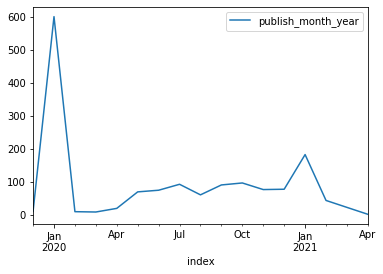

In [98]:
dates_df.plot(x ='index', y = 'publish_month_year')

## Clustering

Below, for both these two groups of papers (before and after COVID-19 outbreak), we follow the same data processing. The steps followed are:

* Tokenization of the papers' abstracts text
* Stemming of the tokens 
* Use of the TfidfVectorizer 

In [63]:
texts_before = asthma_before_covid["abstract_lower"].tolist()

In [64]:
def custom_tokenizer(str_input):
    
    stemmer = PorterStemmer()
    words = nltk.word_tokenize(str_input)
    words = [word for word in words if word.lower() not in sw]

    words = [word.replace('â¡', '') for word in words]
    words = [word.replace('â¢', '') for word in words]
    words = [word.replace('â£', '') for word in words]
    
    words = [''.join(c for c in word if c not in string.punctuation+'©±×≤≥●＜--“”→„') for word in words]
    words = [word for word in words if word not in ['‘', '’', '„']]
        
    words = [word for word in words if word]
    words = [word for word in words if not any(char.isdigit() for char in word)]
    
    #remove stop words before stemming - nltk list of stop words - read file and tolist
    words = [stemmer.stem(word) for word in words]
    return words

In [65]:
string_test = "Wilson Tour 110 we Tennis Racket The Wilson Tour 110 Tennis myself Racket is a fantastic choice for any new starter to the sport, with its lightweight frame it allows easy swing. Its gripped handle promotes a comfortable feel and assists in controlling shots."

In [66]:

custom_tokenizer(string_test)

['wilson',
 'tour',
 'tenni',
 'racket',
 'wilson',
 'tour',
 'tenni',
 'racket',
 'fantast',
 'choic',
 'new',
 'starter',
 'sport',
 'lightweight',
 'frame',
 'allow',
 'easi',
 'swing',
 'grip',
 'handl',
 'promot',
 'comfort',
 'feel',
 'assist',
 'control',
 'shot']

In [67]:
vec_before = TfidfVectorizer(min_df=5,tokenizer=custom_tokenizer,
                             max_features=2000,
                      stop_words='english')
matrix_before = vec_before.fit_transform(texts_before)
df_before = pd.DataFrame(matrix_before.toarray(), columns=vec_before.get_feature_names())
df_before.head()

c:\users\katerina\appdata\local\programs\python\python37\lib\site-packages\sklearn\feature_extraction\text.py:386: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['afterward', 'alon', 'alreadi', 'alway', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becom', 'besid', 'cri', 'describ', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'otherwis', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'thenc', 'thereaft', 'therebi', 'therefor', 'thu', 'togeth', 'twelv', 'twenti', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev'] not in stop_words.



,aberr,abil,abl,abnorm,absenc,absent,absolut,absorpt,abstract,abund,...,x,xray,year,yield,young,younger,yr,α,β,–
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.039204,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.035414,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The Kmeans is explained here:
https://towardsdatascience.com/understanding-k-means-clustering-in-machine-learning-6a6e67336aa1

In [68]:
number_of_clusters=10
km_before = KMeans(n_clusters=number_of_clusters)
km_before.fit(matrix_before)

KMeans(n_clusters=10)

Let's have an over view of our cluster's centers (centroids) anf labels. After that, we get the top terms for every cluster. In other wrods, we see which are the most frequently mentioned words per cluster. Note: since we have used Stemming, we only have the root of the words now.

In [69]:
centroids_before, labels_before = km_before.cluster_centers_, km_before.labels_
print(centroids_before)
print(labels_before)

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.90991050e-03 2.36683528e-03 8.34896617e-04 ... 3.18043019e-03
  3.41301521e-03 0.00000000e+00]
 [0.00000000e+00 6.46407921e-04 6.97031105e-04 ... 0.00000000e+00
  0.00000000e+00 5.02299294e-03]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 6.24482512e-03 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [5.62824701e-05 3.14812331e-03 9.05220075e-04 ... 0.00000000e+00
  1.66265309e-03 2.32046700e-04]]
[2 6 3 ... 5 6 0]


In [70]:
print("Top terms per cluster:")
order_centroids_before = km_before.cluster_centers_.argsort()[:, ::-1]
terms = vec_before.get_feature_names()
for i in range(number_of_clusters):
    top_ten_words = [terms[ind] for ind in order_centroids_before[i, :20]]
    print("Cluster {}: {}".format(i, ' '.join(top_ten_words)))

Top terms per cluster:
Cluster 0: wheez children asthma risk bronchiol respiratori infant factor infect viral ill recurr age earli associ year develop episod childhood rhinoviru
Cluster 1: airway inflamm cell mice respons infect remodel increas asthma hyperrespons inflammatori bronchial subject epitheli exud induc allerg viral mechan chang
Cluster 2: respiratori children detect infect patient virus viru viral exacerb rhinoviru hmpv hospit asthma rsv sampl tract clinic pathogen acut influenza
Cluster 3: cell express activ protein diseas lung infect receptor respons immun inflammatori macrophag role regul gene human function type asthma therapeut
Cluster 4: exacerb asthma infect respiratori viral diseas virus develop review respons immun associ caus viru role mechan factor host current trigger
Cluster 5: diseas pulmonari cough lung chronic respiratori use asthma patient copd effect acut condit treatment exposur obstruct clinic ventil review therapi
Cluster 6: asthma patient children ci u

In [71]:
order_centroids_before
#word with index 1049 has highest Tfidf value in the first array

array([[1971,  285,  148, ..., 1095, 1096,    0],
       [  68,  917,  263, ...,  753,  752, 1999],
       [1568,  285,  486, ..., 1545,  671,    0],
       ...,
       [1359,  920, 1309, ..., 1124, 1125,    0],
       [ 832,  835,  285, ..., 1164, 1166,    0],
       [1284, 1309, 1018, ..., 1142,  404,  999]], dtype=int64)

PCA and its implementation in Python is explained here: https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html

In [72]:
T = preprocessing.Normalizer().fit_transform(df_before)
# Dimesionality reduction to 2
pca_model = PCA(n_components=2)
pca_model.fit(T) 
T = pca_model.transform(T) 

# transform the 'centroids of KMean'

centroid_pca = pca_model.transform(centroids_before)


In [73]:
asthma_before_covid['labels'] = km_before.labels_
asthma_before_covid['pca_1'] = T[:, 0]
asthma_before_covid['pca_2'] = T[:, 1]

In [74]:
asthma_before_covid['labels'] = asthma_before_covid['labels'].astype(str)

In [75]:
fig = px.scatter(asthma_before_covid, 
                 x="pca_1", 
                 y="pca_2", 
                 color="labels",
                 hover_data=['title'])

In [76]:
fig.show()

#### After covid-19

In [77]:
texts_after = asthma_after_covid["abstract_lower"].tolist()

In [78]:
vec_after = TfidfVectorizer(tokenizer=custom_tokenizer,
                      stop_words='english', 
                           max_features=1000)
matrix_after = vec_after.fit_transform(texts_after)
df_after = pd.DataFrame(matrix_after.toarray(), columns=vec_after.get_feature_names())


c:\users\katerina\appdata\local\programs\python\python37\lib\site-packages\sklearn\feature_extraction\text.py:386: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['afterward', 'alon', 'alreadi', 'alway', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becom', 'besid', 'cri', 'describ', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'otherwis', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'thenc', 'thereaft', 'therebi', 'therefor', 'thu', 'togeth', 'twelv', 'twenti', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev'] not in stop_words.



In [79]:
df_after.head()

,abil,abl,abnorm,absenc,abstract,access,accord,account,accumul,achiev,...,world,worldwid,wors,worsen,wuhan,year,york,young,younger,youth
0,0.0,0.0,0.0,0.0,0.091392,0.0,0.082014,0.090468,0.0,0.0,...,0.077856,0.0,0.0,0.0,0.0,0.148058,0.0,0.098751,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.076644,0.0,0.000000,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0


In [80]:
number_of_clusters=10
km_after = KMeans(n_clusters=number_of_clusters)
km_after.fit(matrix_after)
km_after.fit

<bound method KMeans.fit of KMeans(n_clusters=10)>

In [81]:
centroids_after, labels_after = km_after.cluster_centers_, km_after.labels_
print(centroids_after)
print(labels_after)

[[0.00521313 0.00253091 0.00183096 ... 0.         0.         0.        ]
 [0.00209923 0.00563217 0.00297649 ... 0.00165413 0.0031063  0.00707419]
 [0.00071518 0.00220644 0.00945399 ... 0.00503045 0.0024035  0.        ]
 ...
 [0.00814159 0.         0.         ... 0.         0.         0.        ]
 [0.00430158 0.00136956 0.         ... 0.         0.         0.        ]
 [0.00556288 0.00186297 0.00291856 ... 0.00341947 0.00159935 0.        ]]
[6 9 3 ... 1 6 8]


In [82]:
print("Top terms per cluster:")
order_centroids_after = km_after.cluster_centers_.argsort()[:, ::-1]
terms = vec_after.get_feature_names()
for i in range(number_of_clusters):
    top_ten_words = [terms[ind] for ind in order_centroids_after[i, :20]]
    print("Cluster {}: {}".format(i, ' '.join(top_ten_words)))

Top terms per cluster:
Cluster 0: lung diseas pulmonari respiratori chronic patient copd obstruct fibrosi function measur asthma includ pandem review treatment coronaviru effect mechan role
Cluster 1: health diseas patient asthma care use studi risk condit individu pandem report telemedicin case sever includ data medic test chronic
Cluster 2: patient sever case diseas hospit asthma symptom clinic day studi comorbid present infect treatment receiv coronaviru group age report respiratori
Cluster 3: ci patient p risk hospit diseas mortal asthma associ age comorbid factor icu sever higher death outcom studi diabet copd
Cluster 4: patient asthma allerg biolog allergi recommend pandem sever diseas treatment risk manag therapi current corticosteroid infect care use provid continu
Cluster 5: air pollut health lockdown exposur human impact qualiti particul reduc environment asthma citi matter econom respiratori effect children level chang
Cluster 6: children pediatr asthma patient hospit infect

In [83]:
order_centroids_after

array([[512, 262, 717, ..., 738, 736, 999],
       [387, 262, 633, ..., 449, 855, 295],
       [633, 828, 126, ...,  69, 531, 999],
       ...,
       [332, 369, 129, ..., 557, 556, 499],
       [275, 539, 956, ..., 558, 563, 499],
       [441, 129, 777, ..., 278, 614, 999]], dtype=int64)

In [84]:
T_after = preprocessing.Normalizer().fit_transform(df_after)
# Dimesionality reduction to 2
pca_model = PCA(n_components=2)
pca_model.fit(T_after) 
T_after = pca_model.transform(T_after) 

centroid_pca_after = pca_model.transform(centroids_after)

In [85]:
asthma_after_covid['labels'] = km_after.labels_
asthma_after_covid['pca_1'] = T_after[:, 0]
asthma_after_covid['pca_2'] = T_after[:, 1]

In [86]:
asthma_after_covid['labels'] = asthma_after_covid['labels'].astype(str)

In [87]:
fig = px.scatter(asthma_after_covid, 
                 x="pca_1", 
                 y="pca_2", 
                 color="labels",
                 hover_data=['title'])

In [88]:
fig.show()